# TP signal no 2 : IMAC 2. Année 2021-2022.

Dans ce TP, nous abordons le sujet de la synthèse de filtres RIF par la méthode très populaire dite *méthode de la fenêtre* (en anglais : *Windowing Design Method*). 


Les bibliothèques et fonctions utilisées dans ce *notebook* : 


In [ ]:
%matplotlib notebook   
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile as io
from IPython.display import Audio
from scipy import signal


def Periodogramme_dB(data):
    nb_fft=2**(int(np.log2(len(data)))) ### la moitie du nb de points fft
    D=np.fft.fft(data,nb_fft*2)
    f_fft=np.arange(0,nb_fft)/(nb_fft*2)
    return f_fft , 10*np.log10(1/len(data)*(np.abs(D[0:nb_fft]))**2)

def Coder_WAV(nom , signal, Fe):
    M = np.max(np.abs(signal))
    y=0.3*signal/M 
    ### le facteur 0.2 pour éviter d'exploser les oreilles...
    scaled = np.round(32757*y)   ### entre -32767 et +32757
    ### conversion entiers 16 bits: 
    newdata = scaled.astype(np.int16)   
    io.write(nom, Fe, newdata) 
    return

def Bode(N,D):
    ### les polynomes : par ex [1 , 2 , 1] est associé à  z^2+2z+1
    ### N : numérateur du filtre rationnel
    ### D : dénominateur 
    ### renvoie : 1) frequences 2) gain en dB   3) phase en degrés
    if len(D)<len(N):
        print("pas  un filtre causal")
        return 
    p=len(D)-1
    q=len(N)-1
    if q<p:
        N=np.append(np.zeros(p-q) , N)
    nb_fft=2048
    N_fft = np.fft.fft(N,nb_fft*2)
    D_fft = np.fft.fft(D,nb_fft*2)
    H_fft=N_fft/D_fft
    freqs_fft=np.arange(0,nb_fft)/(2*nb_fft)
    Gain_dB  = 20*np.log10(np.abs(H_fft[0:nb_fft]))
    Phase_degres = 180/np.pi*np.angle(H_fft[0:nb_fft])
    return freqs_fft , Gain_dB , Phase_degres


def Developper(poly):
    ### poly est le vecteur des racines
    degre=len(poly)
    poly_dev=np.array([1.0])
    for k in range(0 , degre):
        poly_dev=np.convolve(poly_dev,np.array([1 , -poly[k-1]]))
    return np.real(poly_dev)

def Filtrage(N,D,x):
    p=len(D)-1
    q=len(N)-1
    if q>p:
        print("ce n'est pas un filtre causal")
        return
    if q<p:
        N=np.append(np.zeros(p-q) , N)
    ## normalisation 
    D=D/D[0]
    N=N/D[0]
    L=len(x)
    y=np.zeros(L+p)
    x=np.append(np.zeros(p),x)
    for k in range(p,p+L):
        y[k]=-np.inner(D[1:(p+1)],np.flip(y[(k-p):k]))+np.inner(N,np.flip(x[(k-p):(k+1)]))

    return y[p:(L+p)]

## Définitions : cas de la fenêtre rectangulaire (troncature)

L'étude qui suit est menée dans le cas d'un filtre passe-haut mais la méthodologie présentée s'adapte immédiatement aux filtres passe-bas, passe-bande, coupe-bande. 

Soit donc le filtre idéal passe-haut (fréquence de coupure générique  $0<u_c<0.5$) dont la fonction de transfert  $H_{\text{ideal}}(u)$, réelle et paire, est précisée par le graphe : 


In [ ]:
def GabaritPasseHaut(u,uc):
    return 1*(np.abs(((u+0.5)%1 - 0.5))>uc)

u=np.arange(-0.5,0.5,0.001)
uc=0.2
y=GabaritPasseHaut(u,uc)
plt.figure(1)
plt.plot(u,y,'r',label=r'$H_{ideal}(u)$ : $u_c=0.2$')
plt.legend(loc='center')
plt.grid()
plt.show()
    

Montrez que  la Réponse Impulsionnelle (RI) de ce filtre est : 
\begin{equation}
\begin{cases}
h_{\text{ideal}}[0] & =1-2 u_{c}\\
h_{\text{ideal}}[n] & =-\frac{\sin(2\pi n u_{c})}{\pi n}\ \text{si }n\neq0.
\end{cases}
\end{equation}



Remarquez que c'est une suite non-causale et non-stable. 
Néanmoins, c'est à partir de cette RI que l'on conçoit un filtre de RI notée $h[n]$,  **RIF**, **causal** (et évidemment stable comme tous les filtres RIF). 
Dans toute la suite, $N$ désigne l'ordre de ce filtre c'est-à-dire que les seuls coefficients non-nuls de $h[n]$ sont 
$$
h[n] \ \ , \ \ n\in \{0,1,...,N\}.
$$
(c'est donc un filtre à **$N+1$ coefficients**). 
Nous supposerons enfin que **$N$ est un nombre pair** et nous noterons 
$$
N=2M.
$$

Soit $w[n]$ une fenêtre d'ordre $N$, c'est une suite  causale, positive ayant $N+1$ coefficients : 
$$
w[n]=0 \ \ \text{ si } \ \ n\notin \{0,1,...,N\}.
$$
On définit alors le filtre 
$$
h[n]=h_{\text{ideal}}[n-M]w[n].
$$


Voici représenté le passage de la RI  $h_{\text{ideal}}[n]$ à $h[n]$ (nous avons choisi $N=20$ et $u_c=0.2$) lorsque la fenêtre choisie est la fenêtre rectangulaire (c'est-à-dire la fenêtre $w[n]=1$ pour tout $n\in\{0,1,...,N\})$. 


In [ ]:
def RI_ideal(n,uc):
    h=0.0*n  ### vecteur de même taille que n
    h[n==0]=1-2*uc
    h[n != 0]=1/(np.pi*n[n != 0])*(-np.sin(2*np.pi*n[n != 0]*uc))
    return h

M=10
N=2*M
uc=0.2
indices=np.arange(-20,21)
indices_tronc=np.arange(-M,M+1)
h_ideal=RI_ideal(indices,uc)
h=RI_ideal(indices_tronc,uc)
plt.figure(2)
plt.subplot(211)
plt.plot(indices,h_ideal,'-o',label=r'$h_{ideal}[n]$ : suite infinie non causale')
plt.legend(loc='upper left')
plt.grid()
plt.subplot(212)
plt.plot(indices_tronc+M,h,'-o',label=r'$h[n]$ : RIF causal pour $M=10$')
plt.axvline(x=M,linestyle='--',label=r'$M=10$')
plt.legend(loc='upper left')
plt.grid()





Le gain de ce filtre associé à la fenêtre rectangulaire  peut être étudié analytiquement (ceci est un travail assez pénible que nous éviterons cette année). Voici son graphe (nous avons choisi $N=24$ et $u_c=0.2$) : 

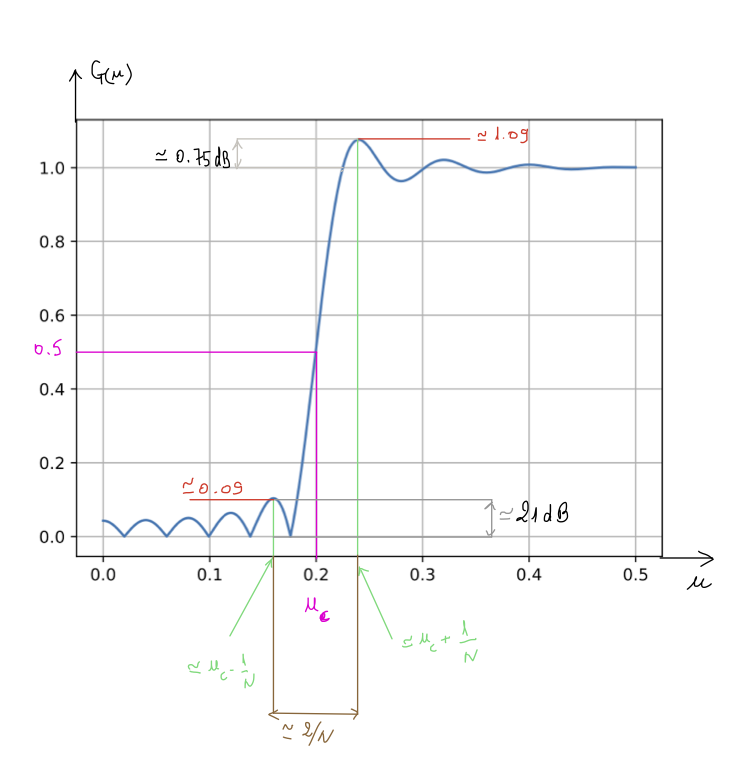
On définit la **bande de transition comme l'intervalle entre la fréquence de l'oscillation la plus haute à gauche de $u_c$ et la fréquence de l'oscillation la plus haute à droite de $u_c$.**    On montre que cette bande, que nous noterons $\Delta u$ vérifie : 
$$
\Delta u \simeq \frac{2}{N}.
$$
L'atténuation en bande de coupure est $21dB$ et en bande passante de $0.75dB$. 



### Question no 1 
Les quelques lignes de code qui suivent vous permettent 
de retrouver le gain du filtre  RIF passe-bas  obtenu 
par la méthode de la fenêtre rectangulaire 
(on parle dans de cas de méthode de la troncature).
Inspirez-vous en pour répondre aux questions suivantes :

- ($N=30$)  Dessinez le graphe des fenêtres de Hamming et Blackmann : vous vous servirez des routines 
$\texttt{signal.hamming(N+1)}$ et $\texttt{signal.blackman(N+1)}$
- ($N=30$, $u_c=0.2$) Dessinez le gain obtenu pour les fenêtres rectangulaire, de Hamming et Blackmann. Calculez à partir des graphiques pour chacun des gains obtenus : la bande de transition, les atténuations (en décibels) en bande passante et en bande de coupure. 

- On trouve dans les livres les valeurs suivantes 

$$
\begin{array}{cccc}
 & \text{bande de transition }\Delta u & \text{Atténuation (bande passante) } & \text{Atténuation (bande de coupure) }\\
\text{fenêtre rectangulaire } & 2/N & 0.75dB & 21dB\\
\text{fenêtre de Hamming} & 4/N & 0.019dB & 53dB\\
\text{fenêtre de Blackman} & 6/N & 0.0017dB & 74dB
\end{array}
$$
Ces résultats sont-ils cohérents avec ceux mesurés dans la question précédente? 
Ceci indique le compromis suivant : soit on privilégie une bande de coupure étroite (le minimum est $2/N$) au prix d'une atténuation en bande de coupure médiocre ou bien on privilégie une très forte atténuation en bande de coupure au prix d'une bande de transition large. On ne peut pas tout avoir...




In [ ]:
M=15
N=2*M
uc=0.2
n=np.arange(-M,M+1)
h=RI_ideal(n,uc)
wR=np.ones(N+1)    ### la fenêtre rectangulaire


D=np.repeat(0,N+1)
D[1]=1
freqs, GR , Phase_R=Bode(h,D)
     

plt.figure(3)
plt.clf()
plt.plot(wR,'o',label='rectangulaire')
#plt.plot(wH,'o',label='Hamming')
#plt.plot(wB,'o',label='Blackman')
plt.legend()
plt.title('graphe de trois fenêtres')


plt.figure(4)
plt.plot(freqs,GR,label='rectangulaire')
#plt.plot(freqs,GH,label='Hamming')
#plt.plot(freqs,GB,label='Blackman')
plt.legend()
plt.grid()
plt.legend(loc=4)
plt.title('Gains obtenus pour N=30')
plt.show()



In [ ]:
M=50

plt.figure(5)
plt.plot(freqs,GR,label='rectangulaire')
plt.plot(freqs,GH,label='Hamming')
plt.plot(freqs,GB,label='Blackman')
plt.legend()
plt.grid()
plt.legend(loc=4)
plt.title('Gains obtenus pour N=100')
plt.show()


### Question no 2 

Dans cette question, on souhaite filtrer le signal  $\texttt{Traverso.wav}$ : le filtre en question est justement un filtre passe-haut dont nous allons donner les caractéristiques.  
   
   On rappelle que le signal en question est un mélange de sinusoïdes dont les fréquences sont des multiples de 
   $$
   u_0=\frac{f_0}{F_e}
   $$
   où $f_0=364$Hz et $F_e=44100$Hz. 
   
   On souhaite atténuer très significativement (dans une proportion supérieure à $60$dB) le fondamental de ce signal (la composante à la fréquence $u_0$) en ne modifiant les amplitudes des autres composantes que dans une proportion inférieure à $0.5$dB. 
   
- Proposer un filtre RIF qui accomplit cette tâche. Vous préciserez l'ordre, la fenêtre utilisée.


- Filtrer le signal (fonction $\texttt{signal.convolve}$) et dessiner dans deux graphes distincts les périodogrammes des deux signaux (filtré et non-filtré). Le filtre a-t-il agi comme ce à quoi nous nous attendions? 

- Concertir le signal filtré en *wave* et écouter le résultat obtenu. Entendez-vous encore la hauteur du signal d'origine? 

Voici ce que l'on peut lire dans l'histoire de la musique (édition de La Pléïade, article de Jacques Brillouin “l'acoustique et la musique”, pages  39) : 

*La hauteur d'un son musical, pur ou complexe, résulte donc du fait que l'oreille informe le cerveau de la présence d'une série harmonique; la hauteur attribuée au son est celle de la fondamentale de cette série même si cette dernière n'existe pas dans le son proposé à l'oreille; les conséquences musicales de ce fait sont importantes. Trois harmoniques successifs, fussent-ils de rang élevé (8, 9 et 10 par exemple), sont entendus comme un son unique dont la hauteur est celle de la fondamentale.*

In [ ]:
###  le filtre passe-haut
f0=364
Fe=44100
u0=f0/Fe
uc=...
M=...
N=2*M
print(N)
n=np.arange(-M,M+1)
h=RI_ideal(n,uc)
wB=signal....(N+1)
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1

freqs, G, Phase = Bode(hB,D)

plt.figure(7)

plt.subplot(211)
plt.plot(h)
plt.subplot(212)
plt.plot(freqs,(G))
plt.show()



#### le signal d'entrée
Fe, x = io.read('Traverso.wav')
#####  le filtrage
y=signal.convolve(hB,x)

####les périodogrammes
frequences_x , I_x = Periodogramme_dB(x)
frequences_y , I_y = Periodogramme_dB(y)
frequences_x=frequences_x*Fe
frequences_y=frequences_y*Fe

plt.figure(8)
plt.clf
plt.subplot(211)
indices=frequences_x<2000
plt.plot(frequences_x[indices],I_x[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.subplot(212)
indices=frequences_y<2000
plt.plot(frequences_y[indices],I_y[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.show()





Coder_WAV('FiltragePH.wav',y,Fe)
audio = Audio(filename='./FiltragePH.wav')
display(audio)
audio = Audio(filename='./Traverso.wav')
display(audio)

### Question no 3

Afin d'illustrer la dernière phrase de J. Brilloin, on se propose de filtrer le signal de violon par un filtre passe-bande. 

- Montrer que le filtre $Q_{\text{ideal}}(u)=1- H_{\text{ideal}}(u)$ est un filtre passe-bas dont la fréquence de coupure est $u_c$. 

- Appelons $q_{\text{ideal}}[n]=\delta[n]-h_{\text{ideal}}(n)$ la RI de ce filtre et donnons-nous une fréquence $0<u_1<1/2$. Calculer en fonction de $Q_{\text{ideal}}$ et $u_1$ la fonction de transfert $R_{\text{ideal}}(u)$ du filtre 
$$
r_{\text{ideal}}[n]=2 q_{\text{ideal}}[n]\cos(2\pi n u_1).
$$

- Montrer que si les conditions 
$$
\begin{cases}
-u_{c}+u_{1}>0 & \text{ et}\\
u_{c}+u_{1}<\frac{1}{2}
\end{cases}
$$
sont réalisées alors le filtre de fonction de transfert $R_{\text{ideal}}(u)$ est un filtre passe-bande dont la bande passante est $\left[ -u_{c}+u_{1} \ , \ u_{c}+u_{1} \  \right]$.

- Synthétiser alors un filtre RIF permettant d'extraire les harmoniques 8, 9 et 10 qui atténue à au moins $60$dB les composantes dans les bandes de coupure.

- Tester ce filtre sur le signal de violon et écouter le résultat. L'expérience permet-elle de confirmer le propos de J. Brillouin? 

In [ ]:
def RI_idealPB(n,uc):
    h=0.0*n  ### vecteur de même taille que n
    h[n==0]=2*uc
    h[n != 0]=1/(np.pi*n[n != 0])*(np.sin(2*np.pi*n[n != 0]*uc))
    return h


u1=...
uc=...
n=np.arange(-M,M+1)
h=RI_idealPB(n,uc)
h=2*h*np.cos(2*np.pi*u1*n)
wB=signal....(N+1)
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1

freqs, G , Phase = Bode(hB,D )

plt.figure(9)
plt.clf()
plt.subplot(211)
plt.plot(h)
plt.subplot(212)
plt.plot(freqs,(G))
plt.show()

y=signal.convolve(hB,x)

####les périodogrammes
frequences_x , I_x = Periodogramme_dB(x)
frequences_y , I_y = Periodogramme_dB(y)
frequences_x=frequences_x*Fe
frequences_y=frequences_y*Fe
plt.figure(10)
plt.clf
plt.subplot(211)
indices=frequences_x<7000
plt.plot(frequences_x[indices],I_x[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.subplot(212)
indices=frequences_y<7000
plt.plot(frequences_y[indices],I_y[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.show()



#### Enregistrement 

Coder_WAV('FiltragePasseBande.wav',y,Fe)
audio = Audio(filename='./FiltragePasseBande.wav')
display(audio)
audio = Audio(filename='./Traverso.wav')
display(audio)

